# Beat AML ML project part 3- Machine learning model to predict AC220 response (Regression)

**Background:** This is the third notebook of the series. If you have not already done so please visit the first notebook for background information on the project and the general plan. In that first notebook we obtained a dataset which contain clinical information, genetic information (mutations), gene expression information and drug sensitivity information of over 400 Acute Myeloid Leukemia (AML) tumor biopsies. This information came from the recent [BEAT AML publication by Tyner et al in Nature](https://www.nature.com/articles/s41586-018-0623-z). We cleaned and combined the clinical, genetic and gene expression datasets into one data set, which will form our features. We are trying to predict whether or not patients will respond to a given therapy with this information. Then for those patients that do respond, we are trying to undertsnad the extent of their response. We can achieve this by stacking two models. First a classifier to catogorize patients into responders and non-responders, then a regressor to predict the extent of response. Tyner et al. tested 112 different therapies against these 400+ patients. This means we will have to solve 112 classifcation and regression problems. **Here I will focus on making a regression model, and interpreting that model, for just one treatment.** In the next notebook we will automate our machine learning pipeline for the other treatments.

**Information abour AC220:** I would like to justify why I chose AC220 as my example case in this notebook. AC220 is of personal interest to me, because I work with it in my day job as an AML researcher. AC220 is also known as Quizartinib. It is currently uner investigation in clinical trials to determine its efficacy either alone or in combination with chemotherapy. The reason why AC220 is so interesting is because it was specifically meant to treat one subset of AML patients, those that have the internal tandem duplication (ITD) mutation in a gene called Flt3. Without getting into too much detail, when Flt3 is mutated with an ITD it is always in an 'on' state which tells the cell to proliferate, divide and grow. Basically Flt3-ITD drive the cancer phenotype. AC220 is one treatment that is meant to turn Flt3-ITD off. The interesting thing is, from the currently published clinical data, we know that not all patients with Flt3-ITD respond to AC220. Also some patients that don't have Flt3-ITD also respond to AC220. It would be really interesting if we could figure out what features determine AC220 sensitivity. 

## Imports and datasets

Lets import our packages and load the dataframes from the previous notebook

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 24
import seaborn as sns
sns.set(font_scale = 2)

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

#Import train test split
from sklearn.model_selection import train_test_split

# Import Machine Learning Models for Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor

# Import Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Import for scoring 
from sklearn.metrics import accuracy_score, make_scorer
import scipy.stats

In [2]:
# Reload the Target and Features dataframes

Features = pd.read_csv('Features.csv')
Features.set_index('LabId', inplace=True)

Targets = pd.read_csv('Targets.csv')
Targets.set_index('LabId', inplace=True)

Features.head()

,CEBPA_Biallelic,isRelapse,isDenovo,isTransformed,priorMalignancyNonMyeloid,cumulativeChemo,priorMalignancyRadiationTx,priorMDS,priorMDSMoreThanTwoMths,priorMDSMPN,...,GALNT7exp,C1RLexp,HLA-Fexp,EIF4A1exp,NARFexp,YPEL2exp,BTN3A2exp,TUBB6exp,MAT2Bexp,AP1S2exp
LabId,,,,,,,,,,,,,,,,,,,,,
13-00098,0,0,1,0,0,1,0,0,0,0,...,59.160975,33.539380,42.109566,225.642033,59.516830,52.488684,45.252956,12.514251,41.190273,49.849423
13-00118,0,1,0,0,0,1,0,0,0,0,...,135.493625,90.068184,39.047906,97.924147,61.485233,66.065462,100.272240,75.834686,101.344825,65.949507
13-00149,0,0,0,0,1,1,0,0,0,0,...,138.230096,31.928819,28.304911,56.609823,87.111042,38.051025,86.946318,0.576531,134.798366,61.084799
13-00157,0,0,1,0,0,1,0,0,0,0,...,148.073938,56.587364,45.798333,36.605639,53.229553,65.091982,77.092026,118.982088,137.229861,135.193157
13-00160,0,0,0,1,0,1,0,1,1,0,...,27.502231,62.321038,68.885714,58.648291,88.001355,43.725944,19.954300,39.185618,51.216037,60.585882


## Reshape the Target and Features datasets

Next, lets pull out only the AC220 data from our Targets dataset. We will to remove a large portion of the samples because their response to the drug is outside the assay window. Those patients with an IC<sub>50</sub> above 2 are non-responders (the concentration in the blood is maximum around 1 micromolar), and those samples with an IC<sub>50</sub> of 0.013717 actually respond very well, but their IC<sub>50</sub> value is again not trustworthy because that is the lowest concentration of AC220 used in the assay. The real IC<sub>50</sub> value is actually lower for these patients. Because the true IC<sub>50</sub> value was not measure for those with a labeled IC<sub>50</sub> of 0.013717, those samples will have to be removed, or they will skew the model.

In [3]:
# Define the function for pulling out AC220 data
def Get_Target (dataset, compound, measurement = 'ic50'):
    Target = dataset[dataset['inhibitor'].str.contains(compound)]
    Target = Target[measurement]
    return Target

# Define the function for making the labels (If doing classification)
def make_label (data, threshold):
    bins = [0, threshold, 10]
    labels = [0,1]    
    label = pd.cut(data, bins = bins, labels = labels)
    return label

# Run function to pull out AC220 IC50 values and make the labels (Classification)
#Target = make_label(Get_Target(Targets, 'AC220'), 2)

# Get the desired Target (Regression)
Target = Get_Target(Targets, 'AC220')

# Remove the non responders
Target = Target[(Target > 0.013717) & (Target < 2)]

# Keep only the rows of Target and Features that are in both dataframes (both)
idx = Target.index.intersection(Features.index)
Target = Target.loc[idx]
Features = Features.loc[idx]

# Find the shape of the new dataframes
print(Target.shape, Features.shape)

(142,) (142, 2687)


Okay now we have our target and features datasets. Unfortunately it looks like there was a lot less overlapp between the Target and Features datasets. This is probably due to limited sample from each patient. 

We also had to remove a bunch of patients whose response was outside the assay window (see above for more detailed explaination). Hopefully 142 samples is still enough that we can learn something!

## Split the data into training, test and validation datasets

Now lets split our data into training, and test data sets. We will use sklearn's Train_test_split here.

If you are not familiar, The training set is what we will use to optimize and train our model, while the test set is what we can use to test the model on untrained data. I opt to keep the test size small (20%) because we have such a small dataset, it would be a shame to lose more of it to testing.

The random_state parameter allows us to reproducibly get the same split (if we keep the parameter unchanged. The convention in the machine learning field is to name your features with a capital X and targets with a lowercase y, which is what I will do here.

(113, 2687)
(113,)
(29, 2687)
(29,)


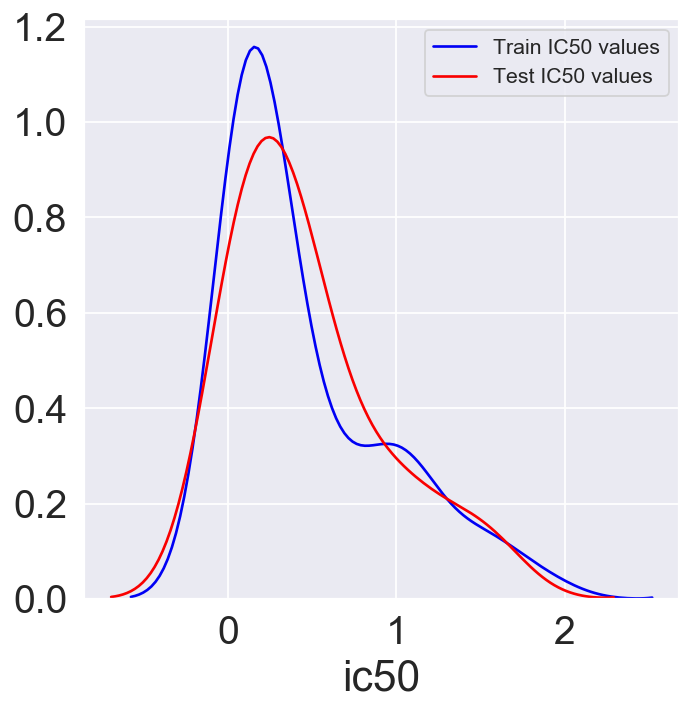

In [4]:
# Split the remaining data into 80% training and 20% testing set
X, X_test, y, y_test = train_test_split(Features, Target, test_size = 0.2, random_state = 30)

# Find out the shape of the datasets
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

# Plot the distribution of the training and test set
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
plt.legend(fontsize = 12)

## Scaling the features

The final step to take before building the models is scaling the features. Some types of machine learning models do not require scaling (i.e. linear regression and random forest). In general I prefer to always scale the data, because we can always reverse the scaling (back transform) after we make our prediction if we have to.

Here we will apply a normalization to scale our data. For a given feature's normalization, the minimum value is subtracted from all data point and then all values are divided by the largest data point. **Using a standardization rather than a normalization could potentially improve the model.** This results in the largest value being set to 1 and the smallest value set to 0. We can easily do this using sklean MinMaxScaler.

In [5]:
# make a scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit to the training data
scaler.fit(X)

# Transform both the training and testing data with the scaler
X = scaler.transform(X)
X_test = scaler.transform(X_test)

#Then lets convert y to a one dimensional array so we can use it for machine learning
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

## Making a Baseline

Now lets determine a baseline for which our model should beat. A baseline is important because we need some metric to beat, or something to prove to us that our model is better than a random guess. The baseline we will use is the **Responders Average.** This baseline take an average IC<sub>50</sub> of all the responders.

The metric we will use to evaluate all of our models and our baselines will be mean absolute error (MAE). There are many metrics to use. **Choosing a different metric may allow for further optimization down the line.** I like MAE because it is easily interpretable because it represents the average amount that the prediction is off by.

In [6]:
# Function to calculate mean absolute error
def MAE(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Define the baseline 
Average = np.mean(y)

# Calculate the Baselines and MAE values
print("The Baseline guess for the AC220 IC50 is {0:.2f}, this baseline has a MAE of {1:.2f}".format(Average, MAE(y_test, Average)))

The Baseline guess for the AC220 IC50 is 0.46, this baseline has a MAE of 0.34


Okay now we have some baselines to beat. The best of the baseline still had a MAE of 0.34. The units on this are micromolar. This is seems like a pretty low bar to beat! 

## Machine learning models -Regression

I chose five machine learning models to evaluate baseline performance. The five I chose all work differently from each other.

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression
6. Kernel ridge regression
7. Gaussian process regression

I will determine the baseline performace of these models and then we can select one model to focus on and do hyperparameter tuning to improve the model even more. The baseline performance is given by just using te sklearn default values for each hyperparameter.

In [7]:
# Make a funtion to fit and evaluate a model. I will take advatage of our MAE function from earlier.
def fit_and_eval(model):
    model.fit(X,y)
    return MAE(y, model.predict(X)), MAE(y_test, model.predict(X_test))
    
# Now lets go through each ML model and return the baseline MAE for each. 

# Linear Regression
LR_MAE, LR_MAE2 = fit_and_eval(LinearRegression())

# SVM
SVM_MAE, SVM_MAE2 = fit_and_eval(SVR())

# Random Forest
RF_MAE, RF_MAE2 = fit_and_eval(RandomForestRegressor(random_state=0))

# Gradient Boosting
GB_MAE, GB_MAE2 = fit_and_eval(GradientBoostingRegressor(random_state=0))

# KNN
KNN_MAE, KNN_MAE2 = fit_and_eval(KNeighborsRegressor(n_neighbors=6))

# Kernel ridge regression
KRR_MAE, KRR_MAE2 = fit_and_eval(KernelRidge(alpha=1.0))

# Gaussian Process regeression
GPR_MAE, GPR_MAE2 = fit_and_eval(GaussianProcessRegressor(random_state=0))


# Print all the outputs
print("The {0} regression model had a training MAE = {1:.2f} and test MAE of {2:.2f}".format("linear", LR_MAE, LR_MAE2))
print("The {0} regression model had a training MAE = {1:.2f} and test MAE of {2:.2f}".format("support vector machine", SVM_MAE, SVM_MAE2))
print("The {0} regression model had a training MAE = {1:.2f} and test MAE of {2:.2f}".format("random forest", RF_MAE, RF_MAE2))
print("The {0} regression model had a training MAE = {1:.2f} and test MAE of {2:.2f}".format("gradient boosting", GB_MAE, GB_MAE2))
print("The {0} regression model had a training MAE = {1:.2f} and test MAE of {2:.2f}".format("K-nearest neighbors", KNN_MAE, KNN_MAE2))
print("The {0} regression model had a training MAE = {1:.2f} and test MAE of {2:.2f}".format("Kernel ridge regression", KRR_MAE, KRR_MAE2))
print("The {0} regression model had a training MAE = {1:.2f} and test MAE of {2:.2f}".format("Gaussian process regression", GPR_MAE, GPR_MAE2))

The linear regression model had a training MAE = 0.00 and test MAE of 0.36
The support vector machine regression model had a training MAE = 0.28 and test MAE of 0.29
The random forest regression model had a training MAE = 0.14 and test MAE of 0.33
The gradient boosting regression model had a training MAE = 0.00 and test MAE of 0.30
The K-nearest neighbors regression model had a training MAE = 0.27 and test MAE of 0.32
The Kernel ridge regression regression model had a training MAE = 0.01 and test MAE of 0.34
The Gaussian process regression regression model had a training MAE = 0.00 and test MAE of 0.47


## Hyperparameter tuning

It looks like several of these models could potentially be tuned to be better than our baseline. I could not optimize the linear regression model (no tunable hyperparameters), so I did not move on with the model. 

We can tune the hyperparameters using GridSearchCV. I will then print the best paramters and train and test MAE

I also plot the distribution of the predicted IC<sub>50</sub> values according to the model in each case to further convinve myself that the model is actually predicting the values correctly. This is obviously more of a subjective measure of model accuracy, but it is interesting to how bad the distribution can look, even if the MAE is pretty good.

**Note The following steps will take a long time to run, so proceed with caution if you are running this notebook cell by cell.**

Best kernel: sigmoid
Best C: 2.7825594022071245
Best gamma: 0.002335721469090121
Train MAE: 0.20074406616068113
Test MAE: 0.3021928797836318


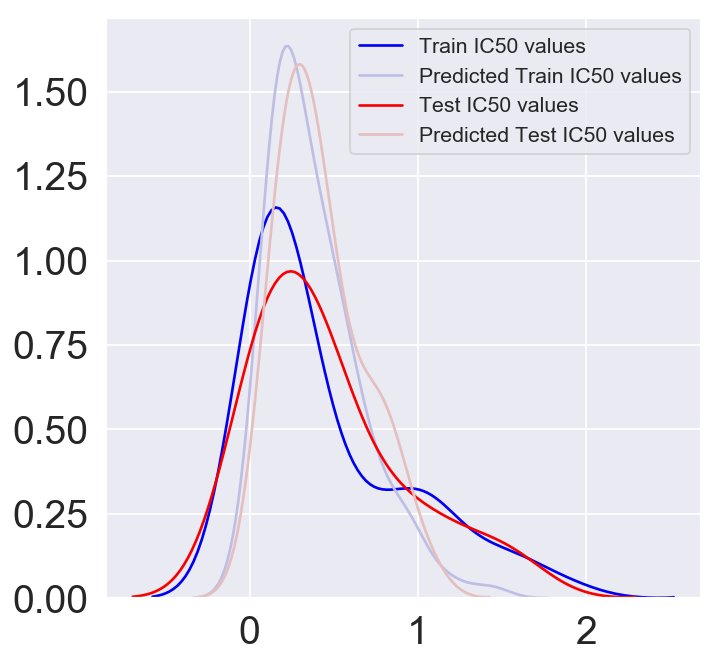

In [8]:
# Hyperparameter tuning for SVR

from sklearn.svm import SVR
# Create SVR regression
SVR = SVR()

# Create hyperparameter spaces
kernel = ['poly','rbf','sigmoid']
C = np.logspace(0, 4, 10)
gamma = np.logspace(-5, 4, 20)

# Create hyperparameter options
hyperparameters = dict(C=C, kernel=kernel, gamma=gamma)

# Create grid search using 5-fold cross validation
Reg = GridSearchCV(SVR, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = Reg.fit(X, y)

# View best hyperparameters and train/test score
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print('Train MAE:', MAE(best_model.predict(X),y))
print('Test MAE:', MAE(best_model.predict(X_test),y_test))
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot(best_model.predict(X), hist= False, label = 'Predicted Train IC50 values', color = '#bebee5')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
sns.distplot(best_model.predict(X_test), hist= False, label = 'Predicted Test IC50 values', color = '#e5bebe')
plt.legend(fontsize = 12)

Best n_estimators: 200
Best max_depth: 3
Best min_samples_leaf: 10
Train MAE: 0.21720529299901262
Test MAE: 0.2863329473363861


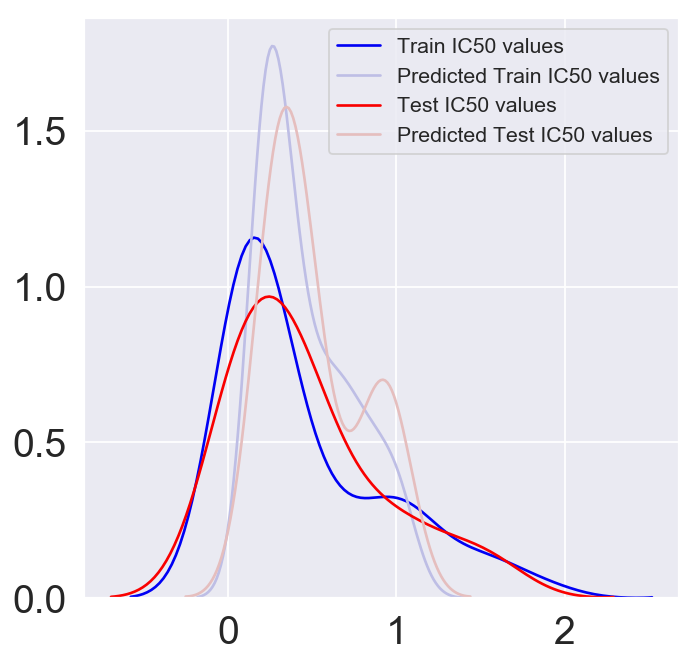

In [9]:
# Hyperparameter tuning for Random forest regression

# Create Random forest regression
rfr = RandomForestRegressor(random_state=0)

# Create hyperparameter spaces
n_estimators= [10, 30, 60, 100, 200]
max_depth= [3, 5, 10, None]
min_samples_leaf= [1, 3, 5, 10]

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

# Create grid search using 5-fold cross validation
Reg = GridSearchCV(rfr, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = Reg.fit(X, y)

# View best hyperparameters and train/test score
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Train MAE:', MAE(best_model.predict(X),y))
print('Test MAE:', MAE(best_model.predict(X_test),y_test))
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot(best_model.predict(X), hist= False, label = 'Predicted Train IC50 values', color = '#bebee5')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
sns.distplot(best_model.predict(X_test), hist= False, label = 'Predicted Test IC50 values', color = '#e5bebe')
plt.legend(fontsize = 12)

Best n_estimators: 30
Best max_depth: 3
Best min_samples_leaf: 10
Train MAE: 0.08476634604852423
Test MAE: 0.31544453065581046


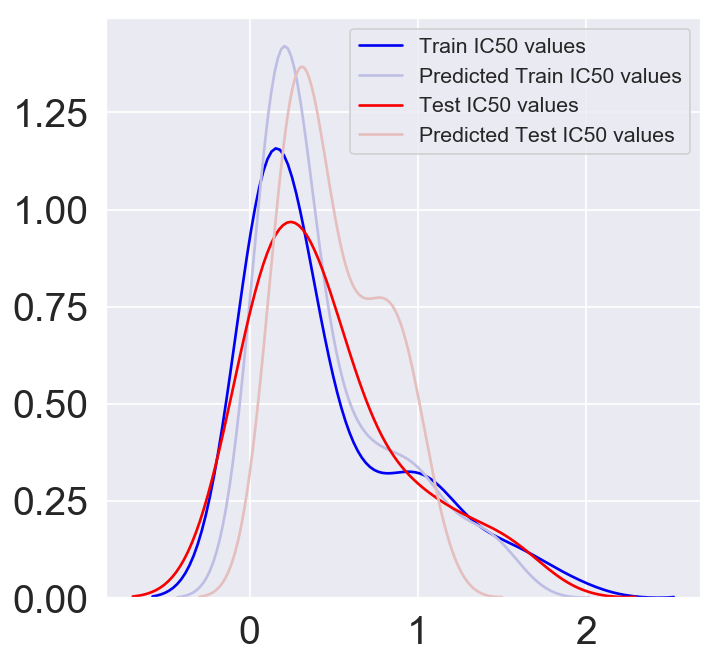

In [10]:
# Hyperparameter tuning for Gradient boosting regression

# Create Gradient Boosting regression
gbr = GradientBoostingRegressor(random_state=0)

# Create hyperparameter spaces
n_estimators= [10, 30, 60, 100, 200, 1000]
max_depth= [3, 5, 10, None]
min_samples_leaf= [1, 3, 5, 10]

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

# Create grid search using 5-fold cross validation
Reg = GridSearchCV(gbr, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = Reg.fit(X, y)

# View best hyperparameters and train/test score
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Train MAE:', MAE(best_model.predict(X),y))
print('Test MAE:', MAE(best_model.predict(X_test),y_test))
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot(best_model.predict(X), hist= False, label = 'Predicted Train IC50 values', color = '#bebee5')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
sns.distplot(best_model.predict(X_test), hist= False, label = 'Predicted Test IC50 values', color = '#e5bebe')
plt.legend(fontsize = 12)

Best n_neighbors: 2
Best weights: distance
Best algorithm: brute
Best leaf_size: 1
Train MAE: 0.0
Test MAE: 0.3448906360631061


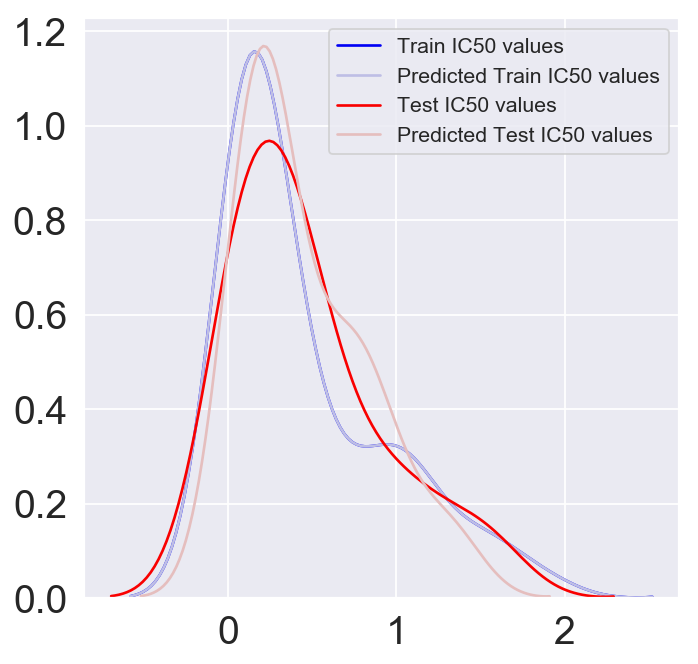

In [11]:
# Hyperparameter tuning for KNN

# Create KNN regression
knn = KNeighborsRegressor(n_neighbors=6)

# Create hyperparameter spaces
n_neighbors = [1,2,3,4,5,6,7,8,9,10]
weights = ['uniform', 'distance']
algorithm = ['ball_tree','kd_tree','brute']
leaf_size = [1,5,10,25,50,100]

# Create hyperparameter options
hyperparameters = dict(n_neighbors=n_neighbors,weights=weights,algorithm=algorithm,leaf_size=leaf_size)

# Create grid search using 5-fold cross validation
Reg = GridSearchCV(knn, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = Reg.fit(X, y)

# View best hyperparameters and train/test score
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', best_model.best_estimator_.get_params()['weights'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Train MAE:', MAE(best_model.predict(X),y))
print('Test MAE:', MAE(best_model.predict(X_test),y_test))
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot(best_model.predict(X), hist= False, label = 'Predicted Train IC50 values', color = '#bebee5')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
sns.distplot(best_model.predict(X_test), hist= False, label = 'Predicted Test IC50 values', color = '#e5bebe')
plt.legend(fontsize = 12)

Best alpha: 59.94842503189409
Best gamma: 1e-05
Train MAE: 0.1768489037106538
Test MAE: 0.30848402583339546


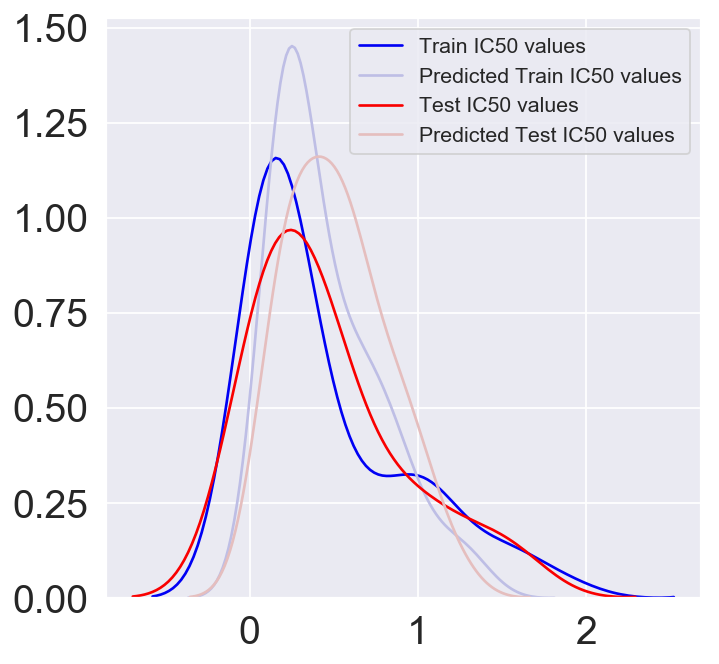

In [12]:
# Hyperparameter tuning for Kernel ridge

# Create kernel ridge regression
kr = KernelRidge(alpha=1.0)

# Create hyperparameter spaces
alpha = np.logspace(0, 4, 10)
gamma = np.logspace(-5, 4, 20)

# Create hyperparameter options
hyperparameters = dict(alpha=alpha,gamma=gamma)

# Create grid search using 5-fold cross validation
Reg = GridSearchCV(kr, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = Reg.fit(X, y)

# View best hyperparameters and train/test score
print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print('Train MAE:', MAE(best_model.predict(X),y))
print('Test MAE:', MAE(best_model.predict(X_test),y_test))
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot(best_model.predict(X), hist= False, label = 'Predicted Train IC50 values', color = '#bebee5')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
sns.distplot(best_model.predict(X_test), hist= False, label = 'Predicted Test IC50 values', color = '#e5bebe')
plt.legend(fontsize = 12)

Best alpha: 1.0
Train MAE: 0.19695630506920989
Test MAE: 0.3417173771198975


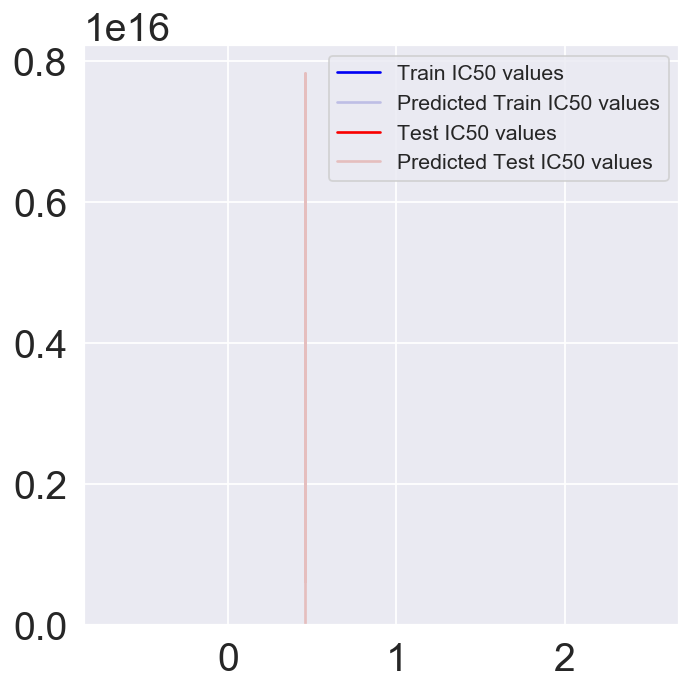

In [13]:
# Hyperparameter tuning for Gaussian Process

# Create Gaussian process regression
gpr = GaussianProcessRegressor(random_state=0, normalize_y=True)

# Create hyperparameter spaces
alpha = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(alpha=alpha)

# Create grid search using 5-fold cross validation
Reg = GridSearchCV(gpr, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = Reg.fit(X, y)

# View best hyperparameters and train/test score
print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Train MAE:', MAE(best_model.predict(X),y))
print('Test MAE:', MAE(best_model.predict(X_test),y_test))
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot(best_model.predict(X), hist= False, label = 'Predicted Train IC50 values', color = '#bebee5')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
sns.distplot(best_model.predict(X_test), hist= False, label = 'Predicted Test IC50 values', color = '#e5bebe')
plt.legend(fontsize = 12)

Train MAE: 0.08476634604852423
Test MAE: 0.31544453065581046


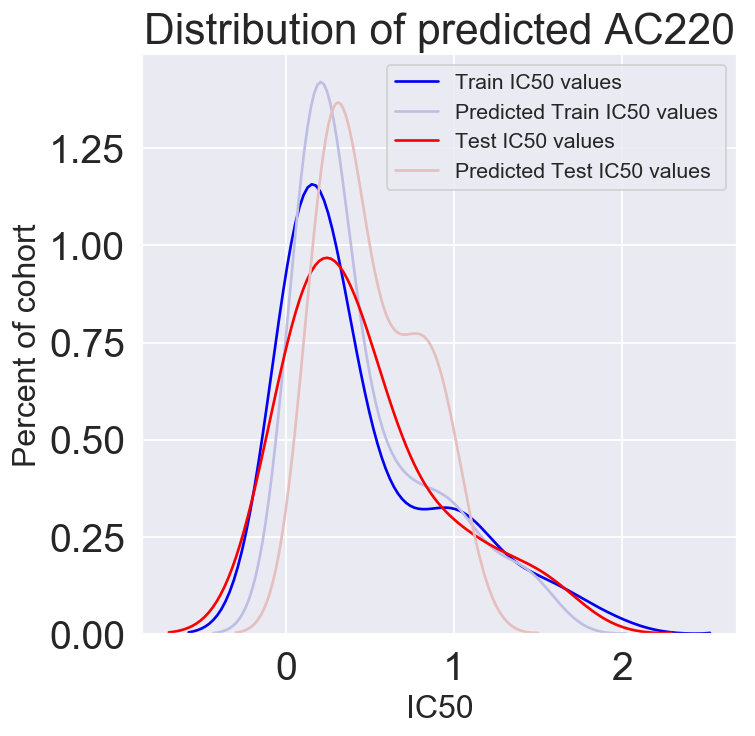

In [14]:
gbr = GradientBoostingRegressor(n_estimators=30, max_depth=3, min_samples_leaf=10, random_state=0)
gbr.fit(X,y)
print('Train MAE:', MAE((gbr.predict(X)),y))
print('Test MAE:', MAE((gbr.predict(X_test)),y_test))
plt.figure(dpi=128, figsize=(6, 6))
sns.distplot(y, hist= False, label = 'Train IC50 values', color= '#0000f4')
sns.distplot((gbr.predict(X)), hist= False, label = 'Predicted Train IC50 values', color = '#bebee5')
sns.distplot(y_test, hist= False, label = 'Test IC50 values', color= '#f90000')
sns.distplot((gbr.predict(X_test)), hist= False, label = 'Predicted Test IC50 values', color = '#e5bebe')
plt.title("Distribution of predicted AC220", fontsize=24)
plt.ylabel("Percent of cohort", fontsize=18)
plt.xlabel("IC50", fontsize=18)
plt.legend(fontsize = 12)

## Learning more about the gradient boosting reggresor model

Gradient boosting regression seems like our best model when the hyperparameters are tuned. Lets explore this model a bit further by making a scatterplot to compare the measured IC<sub>50</sub> values with the predicted IC<sub>50</sub> values.

No handles with labels found to put in legend.


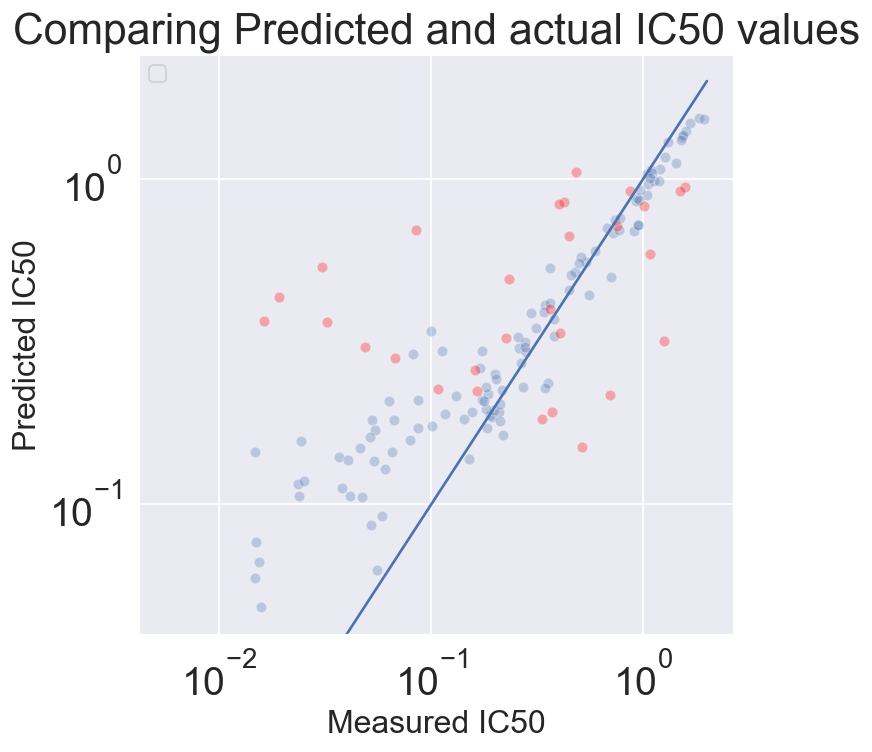

In [15]:
plt.figure(dpi=128, figsize=(6, 6))
sns.scatterplot(x=y, y=gbr.predict(X), alpha=0.3)
sns.scatterplot(x=y_test, y=gbr.predict(X_test), alpha=0.3, color='red')
a=(0,1,1.5,2)
b=(0,1,1.5,2)
plt.plot(a,b)
plt.yscale('log')
plt.xscale('log')
plt.title("Comparing Predicted and actual IC50 values", fontsize=24)
plt.ylabel("Predicted IC50", fontsize=18)
plt.xlabel("Measured IC50", fontsize=18)
plt.legend(fontsize = 12)

It seems like our model is somewhat accurate, but you can clearly tell it has a lot of trouble predicting the very sensitive samples. This might be because some of the information that determines extreme sensitivity to the drug could only be determined from those highly responsive samples we had to remove in the beggining of this notebook. 

Next lets find the feature importances of our model.

In [16]:
Feature_importances_sorted = pd.Series(data= gbr.feature_importances_, index= Features.columns).sort_values(ascending=False)
Feature_importances_sorted.head(15)

MAPK14exp          0.076194
GPIexp             0.069201
TRAK2exp           0.042374
TIMP1exp           0.041982
CERKexp            0.031335
RAB27Aexp          0.029751
AGPSexp            0.025629
PRTN3exp           0.023886
MXD4exp            0.021834
PGDexp             0.019960
ITGAXexp           0.017821
ADRBK1exp          0.017513
CD82exp            0.017382
CTC-575D19.1exp    0.017373
CD38exp            0.017270
dtype: float64

In [17]:
print(Feature_importances_sorted[Feature_importances_sorted.index.str.contains('FLT3')])
print(Feature_importances_sorted[Feature_importances_sorted.index.str.contains('HCK')])
print(Feature_importances_sorted[Feature_importances_sorted.index.str.contains('FGR')])
print(Feature_importances_sorted[Feature_importances_sorted.index.str.contains('LYN')])
print(Feature_importances_sorted[Feature_importances_sorted.index.str.contains('SYK')])

FLT3exp                               0.0
FLT3_missense_variant_D835Y           0.0
FLT3_missense_variant_D835H           0.0
FLT3_internal_tandem_duplication_D    0.0
FLT3-ITD                              0.0
dtype: float64
HCKexp    0.0
dtype: float64
FGRexp    0.0
dtype: float64
LYNexp    0.0
dtype: float64
SYKexp    0.0
dtype: float64


In [18]:
sum(Feature_importances_sorted !=0)

87

So it seems like we have only 87 features that have any weight attached to them. This is surprisingly small considering we started with close to 2,700 features.

Next lets compare MAPK14 expression, which was determined to be the most important feature, to overall response to AC220.

0.47666251316069375 2.0158377429423003e-09


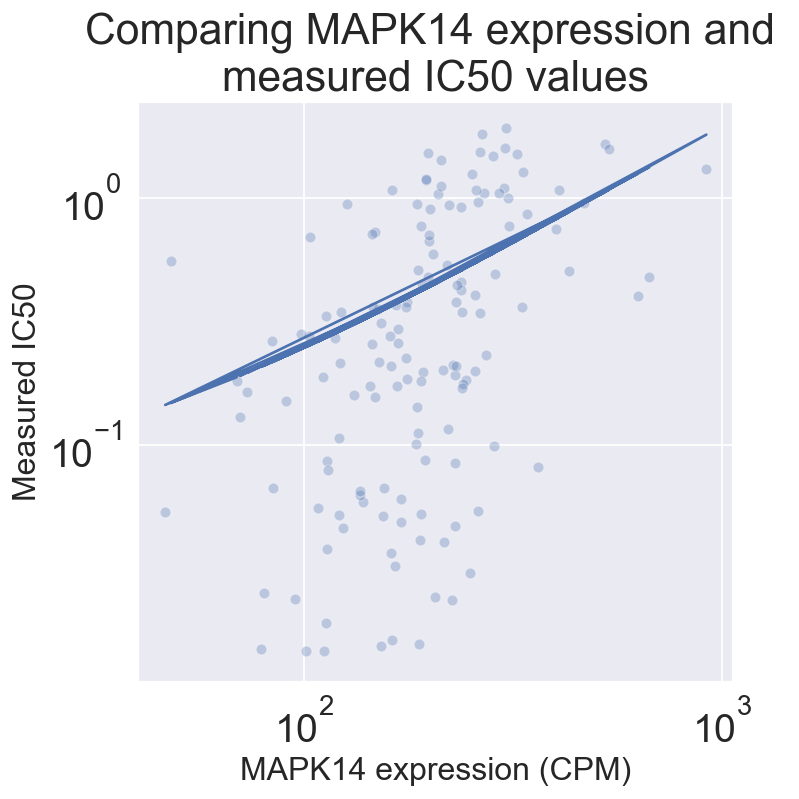

In [19]:
plt.figure(dpi=128, figsize=(6, 6))
sns.scatterplot(x=Features['MAPK14exp'], y=Target, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title("Comparing MAPK14 expression and \nmeasured IC50 values", fontsize=24)
plt.ylabel("Measured IC50", fontsize=18)
plt.xlabel("MAPK14 expression (CPM)", fontsize=18)

# sample points 
X_fit = Features['MAPK14exp']
Y_fit = Target

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Features['MAPK14exp'], Target)
yfit = [intercept + slope * xi for xi in Features['MAPK14exp']]
plt.plot(Features['MAPK14exp'], yfit)
print(r_value, p_value)

We can see that MapK14 gene expression correlated slightly with AC220 resistance. This is quite interesting as Ras mutations are known to be one cause of resistance to AC220. Ras is upstream of Mapk14 and therefore it could be that those ras mutations confer resistance to AC220 by increasing Mapk14 activity. 

Next is just an exercise to satisfy my curiosity. I want to see the difference in response to AC220 with patients that have the FLt3-ITD mutation and those that do not. Flt3-ITD is currently the main marker to determine whether a patient should take AC220.

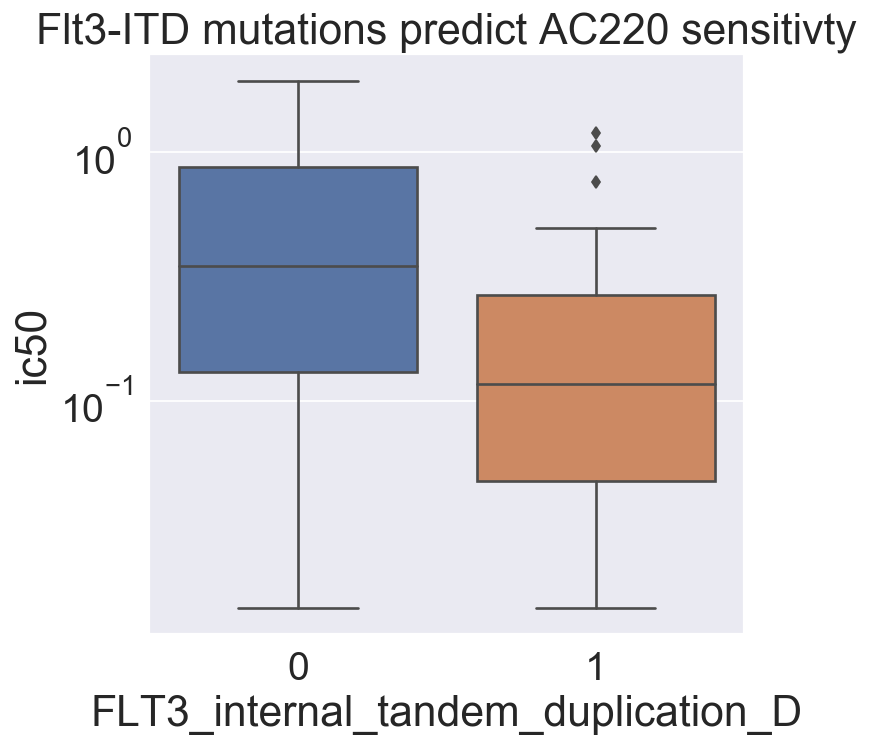

In [20]:
plt.figure(dpi=128, figsize=(6, 6))
sns.boxplot(x=Features['FLT3_internal_tandem_duplication_D'], y =Target)
plt.title("Flt3-ITD mutations predict AC220 sensitivty", fontsize=24)
plt.yscale('log')

In [21]:
a = Target[Features['FLT3_internal_tandem_duplication_D']==0]
b= Target[Features['FLT3_internal_tandem_duplication_D']==1]

scipy.stats.ttest_ind_from_stats(a.mean(), np.sqrt(a.var(ddof=1)), a.size, 
                                 b.mean(), np.sqrt(b.var(ddof=1)), b.size, equal_var=False)

Ttest_indResult(statistic=3.4855681894144213, pvalue=0.0010046895671589197)

We can see that Flt3-ITD is a pretty good marker for drug sensistivity, but not good enough because there is a large overlap between the two boxplots. In other words there are Flt3-ITD mutant tumors that do not respond to the drug and there are tumors without the mutation that do respond to AC220. This was basically to confirm that their is room for improvement to the current paradigm of AC220 treatment.

## Conclusions

In this notebook we made a somewhat accurate model for predicting AC220 response. The main caveat is that the assay window was too small so we can't predict response for those tumors that do not respond at all and those who reponsd extremely well. In the next notebook we will try to automate the process and use gradient boosted decision trees to predict response to several other drugs. All of those drugs should work the same way as AC2200, in that they are all supposed to be FLt3 inhibitors. 